<a href="https://colab.research.google.com/github/brenoskuk/ML_exercises/blob/master/perceptron_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assignement 4 - "Perceptron"**
Breno Skuk et Leonardo Boulitreau


# Question 1

## Library


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from random import random
import time

%matplotlib inline
np.random.seed(seed=666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 1

###Generating Data

The proposed question was developed in the form of building blocks of code.
Initially, it was developed a general function only to generate gaussian data according to a certain mean, covariance and the set size.

In [ ]:
def gaussian_data_generation(n, mean, cov):
  # create data which follows a multivariate Gaussian distribution

  assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
  assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"

  X = np.random.multivariate_normal(mean, cov, n) # actual data
    
  return X

Now, based on the precedent function, it was created a function that generates a dataset with all the questions' rules. That is, if the data is classified with a 1, then the mean input to the previous function is [1,0] and if it is classified with a 0, then the input will become [-1,0]. As demanded, we generate 100 data points for both cases, forming a whole data set. Also, as we will have to vary the set covariance, we set this parameter as input to the function.

In [ ]:
def generate_data_cov(cov = 0.15):
    
  n=100 # same number of samples for each class
  mean_0 = [-1, 0]        
  mean_1 = [1, 0]
  cov_I = np.array([[cov, 0], [0, cov]])
  
  X_0=gaussian_data_generation(n, mean_0, cov_I)
  y_0=np.zeros(n)

  X_1=gaussian_data_generation(n, mean_1, cov_I)
  y_1=np.ones(n)

  X=np.concatenate((X_0,X_1))
  y=np.concatenate((y_0,y_1))
        


  return X, y

Done that, in order to visualize the sets we have built, now we define two plot functions. The first, "plot_data", is used simply to show the data we generated, also, by applying color and shape according to each label, for better visualisation. Since the label is binary, we apply a yellowish color to and a pentagon shape to the label 1, and for the label 0 we apply blue and a circle shape.
For the "plot_result" function, it does exactly the same thing as the previous one, but with the addition of plotting also result that will come out of the perceptron, the line that will separate the data according to its labels.

In [ ]:
def plot_data(X,y):
  fig1 = plt.figure(figsize=(6, 6))
  ax = plt.gca()
  min_tot = np.min(X)
  max_tot = np.max(X)
  symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
  k = np.unique(y).shape[0]
  color_blind_list = sns.color_palette("colorblind", k)
  for i, label in enumerate(y):
      plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                  s=80, marker=symlist[int(label)])
      

def plot_result(X,y,W = [0,0], xylim = 2):
  fig = plt.figure(figsize=(6, 6))
  xx = np.linspace(-5,5,100)
  yy = -(W[0]*xx)/(W[1])
  plt.plot(xx, yy, '-r')
  ax = plt.gca()
  min_tot = np.min(X)
  max_tot = np.max(X)
  symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
  k = np.unique(y).shape[0]
  color_blind_list = sns.color_palette("colorblind", k)
  for i, label in enumerate(y):
      plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                  s=80, marker=symlist[int(label)])
  plt.ylim(-xylim, xylim)
  plt.xlim(-xylim, xylim)
  plt.show()

Now, we generate one set of data for each value of covariance given on the question, to check that our functions work well.

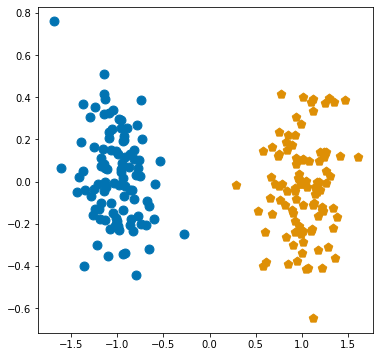

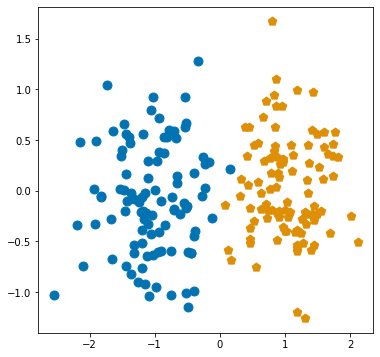

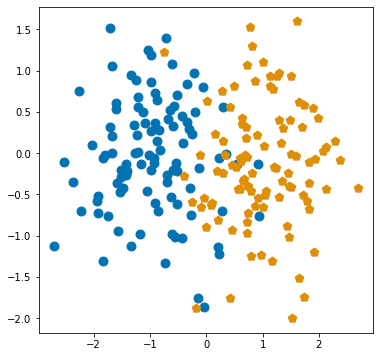

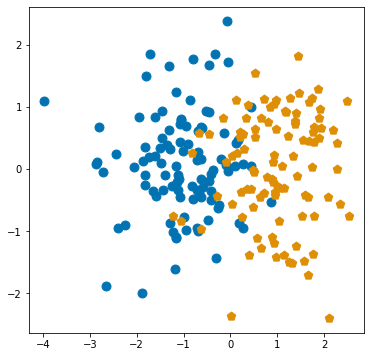

In [ ]:
cov1 = 0.05
cov2 = 0.25
cov3 = 0.50
cov4 = 0.75

X1,y1 = generate_data_cov(cov1)
X2,y2 = generate_data_cov(cov2)
X3,y3 = generate_data_cov(cov3)
X4,y4 = generate_data_cov(cov4) 

plot_data(X1,y1)

plot_data(X2,y2)

plot_data(X3,y3)

plot_data(X4,y4)

### Perceptron Algorithm



With the ability to generate a set, it is now important to build the Perceptron Algorithm. This algorithm was entirely based on the one stated on the Asssignment document. We describe the data and the weight vector as:



$x(n)=[x_{1}(n)\;x_{2}(n) \;1]^{T}$

$w(n)=[w_{1}(n)\;w_{2}(n) \;b]^{T}$


So, we run the algorithm through the data set (n) by updating the weight vectors as follows, with:

-If the data is from the label 1, we have:

$w(n+1) = w(n)\; \; if \; \; w^{T}(n)x(n)>0$

$w(n+1) = w(n)+\eta(n)x(n)\; \; if \; \; w^{T}(n)x(n)\leq0$

-If the data is from the label 0, we have:

$w(n+1) = w(n)-\eta(n)x(n)\; \; if \; \; w^{T}(n)x(n)>0$

$w(n+1) = w(n)\; \; if \; \; w^{T}(n)x(n)\leq0$

In [ ]:
def perceptron(X,y):
  # n is the number of samples and d is the dimension of the space
  n = X.shape[0]
  d = X.shape[1]
  lr = 1
  W = np.zeros(d)
  for i in range(n):
    # deal with class 1
    if y[i] == 1:
      if W.dot(X[i]) <= 0:
        W = W + lr*X[i] # could add a learning parameter as function of i
    # deal with class 2
    else:
        if W.dot(X[i]) > 0:
          W = W - lr*X[i] # could add a learning parameter as function of i
  return W

Now we test on the algortihm on four sets, containing all covariances on the question, to check its functioning and also use the function to plot the result.

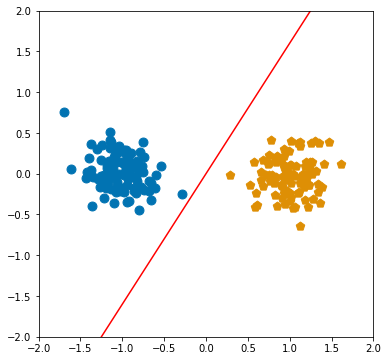

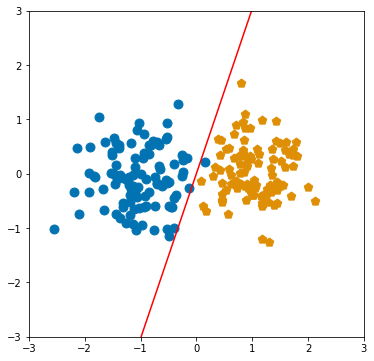

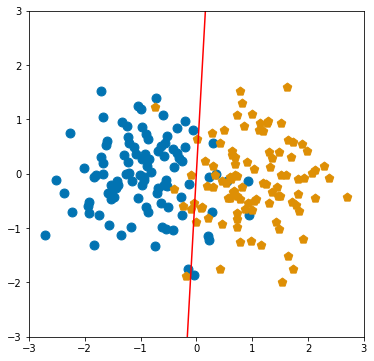

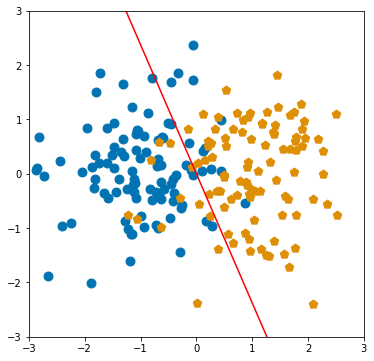

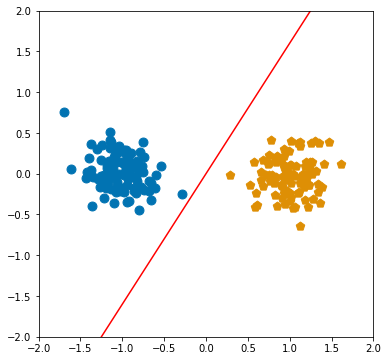

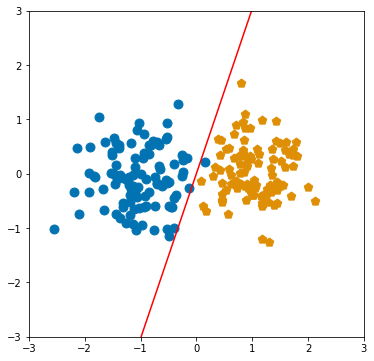

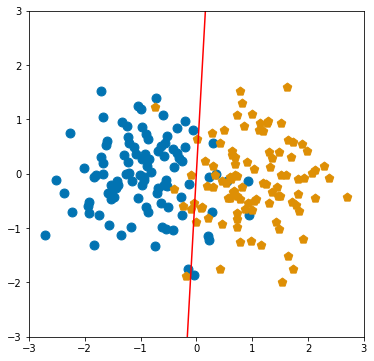

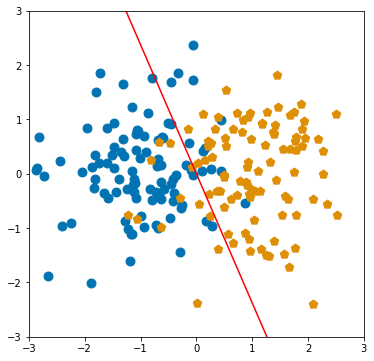

In [ ]:
W1 = perceptron(X1,y1)
W2 = perceptron(X2,y2)
W3 = perceptron(X3,y3)
W4 = perceptron(X4,y4)

plot_result(X1,y1, W1)
plot_result(X2,y2, W2, 3)
plot_result(X3,y3, W3, 3)
plot_result(X4,y4, W4, 3)


###Computing the Errors

Having the algorithm running, we now have to check its performance, so we created a simple function that evaluates the total number of errors based on the scalar product, as mentioned above.

In [ ]:
def calculate_errors(W, X_test,y_test):
  n_errors = 0
  n = X_test.shape[0]
  d = X_test.shape[1]
  for i in range(n):
    # adds coordinate to test with W
    xx = X_test[i]
    # errors are given by checking scalar product  
    # deal with class 1
    if y_test[i] == 1:
      if W.dot(xx) <= 0:
        n_errors = n_errors + 1
    # deal with class 2
    if y_test[i] == 0:
      if W.dot(xx) > 0:
        n_errors = n_errors + 1
  return n_errors


And lastly, we define the solver function. It will generate fifty datasets, as demanded, and run the perceptron on each one. Then it calculate the errors, the average error, and the standard deviation. The only parameter that it receives is the covariance of the fifty sets that will be generated.

In [ ]:
def test_50_times(cov):
  n_errors = np.zeros(50)
  # count errors for 50 iterations
  for i in range(50):
    # generate each test set for a given covariance
    X_test,y_test = generate_data_cov(cov)
    # Run the perceptron
    W = perceptron(X_test,y_test)

    # get for each iterations the errors
    it_err_ = calculate_errors(W,X_test,y_test)
    n_errors[i] = it_err_

  avg_error = n_errors.sum()/50
  # calculates the standard deviation of errors
  std_dev = 0
  for i in range(50):
    std_dev = std_dev + (n_errors[i] - avg_error)**2
  std_dev = (1/50*std_dev)**(0.5)
  return avg_error, std_dev

Now we run the the function for each value of covariance.

In [ ]:
avg_error1, std_dev1 = test_50_times(cov1)
print ("case 1\nmean errors = ",avg_error1, "standard deviation = ", std_dev1)
avg_error2, std_dev2 = test_50_times(cov2)
print ("case 2\nmean errors = ",avg_error2, "standard deviation = ", std_dev2)
avg_error3, std_dev3 = test_50_times(cov3)
print ("case 3\nmean errors = ",avg_error3, "standard deviation = ", std_dev3)
avg_error4, std_dev4 = test_50_times(cov4)
print ("case 4\nmean errors = ",avg_error4, "standard deviation = ", std_dev4)

case 1
mean errors =  0.0 standard deviation =  0.0
case 2
mean errors =  6.22 standard deviation =  5.56161846947451
case 3
mean errors =  28.22 standard deviation =  29.345043874562528
case 4
mean errors =  39.04 standard deviation =  25.18091340678491


### Part 1 Plot

And thus, we have the plot.

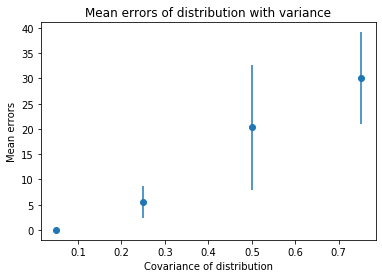

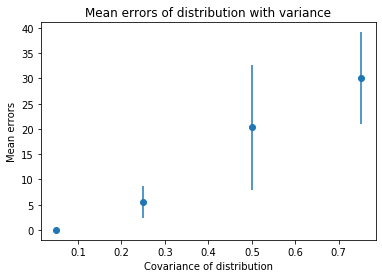

In [ ]:
x = np.array([cov1, cov2, cov3, cov4])
y = np.array([avg_error1,avg_error2,avg_error3,avg_error4])
e = np.array([std_dev1,std_dev2,std_dev3,std_dev4])

plt.errorbar(x, y, e, linestyle='None', marker='o')
plt.title("Mean errors of distribution with variance")
plt.xlabel("Covariance of distribution")
plt.ylabel("Mean errors")
plt.show()

## Part 2

### Generating Data

For the second part, it is demanded that we generate a dataset with covariance of 0.15:

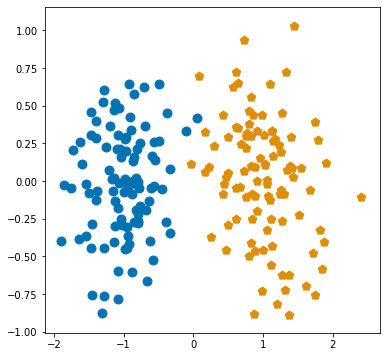

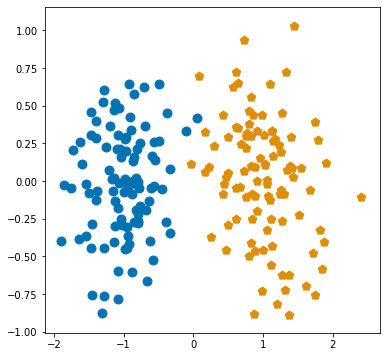

In [ ]:
cov_part2 = 0.15
X_part2, y_part2 = generate_data_cov(cov_part2)
plot_data(X_part2,y_part2)

After that, it demands us that we generate a new dataset by changing each of the labels with a probablity p of change:

In [ ]:
def shuffle_labels(y,p): # shuffle labels with probability p
  y_n = np.copy(y)
  for i in range(y_n.shape[0]):
    if (random() < p):
      # change labels here
      if y_n[i] == 0:
        y_n[i] = 1
      else:  
        y_n[i] = 0
  return y_n

### Shuffling and Calculating weights


Now we created four datasets based on the previous, by shuffling them with the four different probabilities that were given, and plot them to visualise the mixture

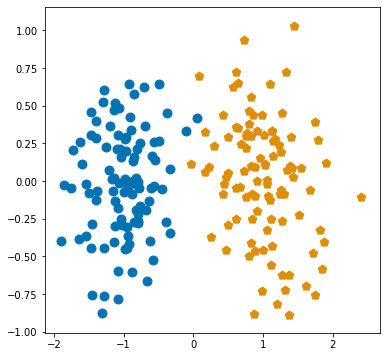

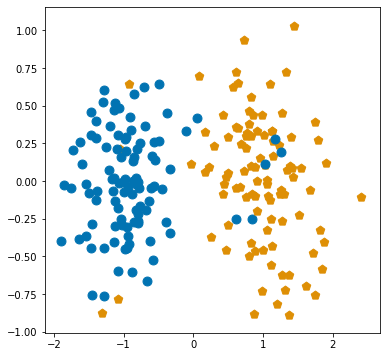

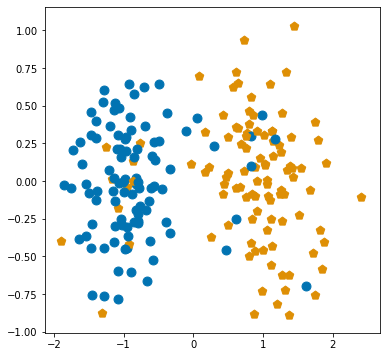

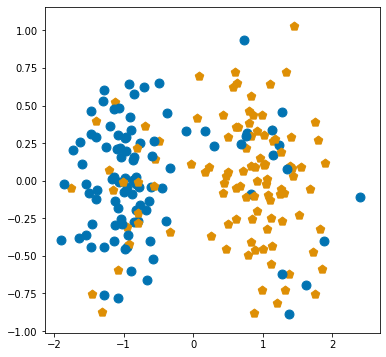

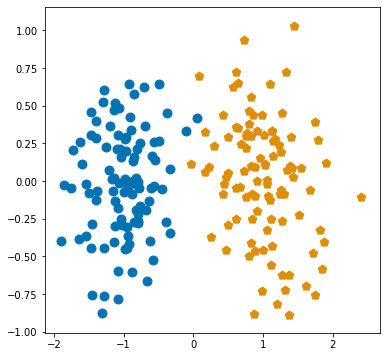

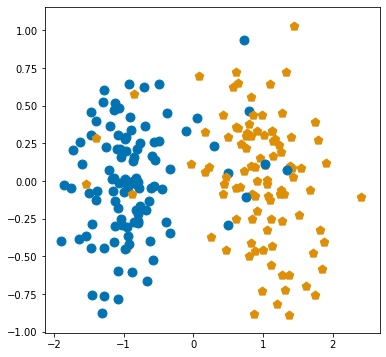

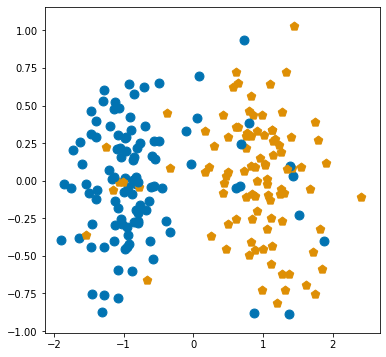

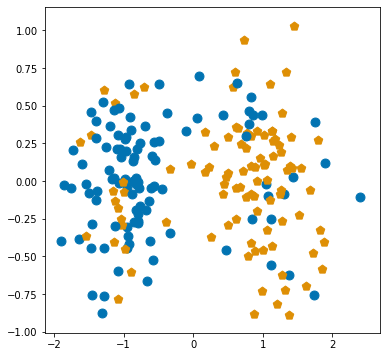

In [ ]:
y_shuffled1 = shuffle_labels(y_part2,0)
plot_data(X_part2,y_shuffled1)
y_shuffled2 = shuffle_labels(y_part2,0.05)
plot_data(X_part2,y_shuffled2)
y_shuffled3 = shuffle_labels(y_part2,0.1)
plot_data(X_part2,y_shuffled3)
y_shuffled4 = shuffle_labels(y_part2,0.2)
plot_data(X_part2,y_shuffled4)

Now we define the same function as above, by just adding a parameter p that will shuffle the set labels

In [ ]:
def test_50_times_shuffle(cov,p):
  n_errors = np.zeros(50)
  # count errors for 50 iterations
  for i in range(50):
    # generate test set for a given covariance
    X_test,y_test = generate_data_cov(cov)
    y_test_s = shuffle_labels(y_test,p)

    W = perceptron(X_test,y_test_s)
    # get for each iterations the errors
    it_err_ = calculate_errors(W,X_test,y_test_s)
    
    n_errors[i] = it_err_
  avg_error = n_errors.sum()/50
  # calculates the standard deviation of errors
  std_dev = 0
  for i in range(50):
    std_dev = std_dev + (n_errors[i] - avg_error)**2
  std_dev = (1/50*std_dev)**(0.5)
  return avg_error, std_dev

### Computing Errors

Compute the error for the four different p's

In [ ]:
avg2_error1, std2_dev1 = test_50_times_shuffle(cov_part2,0)
print ("case 1\nmean errors = ",avg2_error1, "standard deviation = ", std2_dev1)
avg2_error2, std2_dev2 = test_50_times_shuffle(cov_part2,0.05)
print ("case 2\nmean errors = ",avg2_error2, "standard deviation = ", std2_dev2)
avg2_error3, std2_dev3 = test_50_times_shuffle(cov_part2,0.1)
print ("case 3\nmean errors = ",avg2_error3, "standard deviation = ", std2_dev3)
avg2_error4, std2_dev4 = test_50_times_shuffle(cov_part2,0.2)
print ("case 4\nmean errors = ",avg2_error4, "standard deviation = ", std2_dev4)

case 1
mean errors =  0.92 standard deviation =  1.1106754701531856
case 2
mean errors =  15.32 standard deviation =  16.035510593679266
case 3
mean errors =  35.5 standard deviation =  38.91439322410154
case 4
mean errors =  65.02 standard deviation =  38.31056773267657
case 1
mean errors =  0.92 standard deviation =  1.1106754701531856
case 2
mean errors =  15.42 standard deviation =  11.200160713132647
case 3
mean errors =  45.7 standard deviation =  52.34892549040524
case 4
mean errors =  64.28 standard deviation =  35.22501383959984


### Plot Part 2

And for last, we do the plot

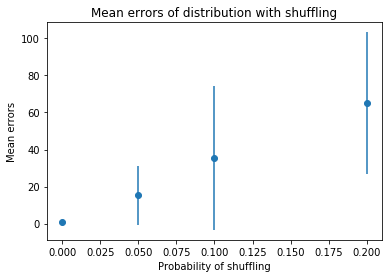

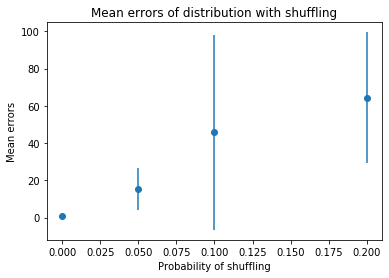

In [ ]:
x = np.array([0, 0.05, 0.1, 0.2])
y = np.array([avg2_error1,avg2_error2,avg2_error3,avg2_error4])
e = np.array([std2_dev1,std2_dev2,std2_dev3,std2_dev4])

plt.errorbar(x, y, e, linestyle='None', marker='o')
plt.title("Mean errors of distribution with shuffling")
plt.xlabel("Probability of shuffling")
plt.ylabel("Mean errors")
plt.show()